In [1]:
import os, gc, sys
import pygrib
import regionmask
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import multiprocessing as mp
import matplotlib.pyplot as plt 
import matplotlib as mpl

from glob import glob
from numpy import trapz
from scipy.integrate import simps
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

import warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS'] = '1'

In [14]:
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 
cwa = 'SEW'#sys.argv[1]
fhr_start, fhr_end, fhr_step = 24, 168, 24#108, 6

ver = '4p0'
start_date = datetime(2020, 10, 1, 0)
end_date = datetime(2021, 1, 1, 0)

# start_date = datetime(2020, 10, 1, 0)
# end_date = datetime(2020, 12, 1, 0)

interval = 24

produce_thresholds = [0.01, 0.1, 0.25, 0.50, 1.0]
bint, bins_custom = 10, None

cwa_bounds = {
    'WESTUS':[30, 50, -130, -100],
    'SEW':[46.0, 49.0, -125.0, -120.5],
    'SLC':[37.0, 42.0, -114.0, -110],
    'MSO':[44.25, 49.0, -116.75, -112.25],
    'MTR':[35.75, 38.75, -123.5, -120.25],}

n_events = 3
cx = 8 if cwa == 'WESTUS' else 4
cy = cx
# CONFIG # # CONFIG # # CONFIG # # CONFIG # # CONFIG # 

In [3]:
nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
fig_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/'
os.makedirs(tmp_dir, exist_ok=True)

In [4]:
def custom_cbar(_bins):
    
    base_colors = ['#a6611a','#dfc27d','white','#80cdc1','#018571'][::-1]
    lev = np.unique([0, _bins[0]-10, _bins[0], _bins[1]+10, _bins[1], 100])
    lev = lev[((lev >= 0) & (lev <= 100))]

    if _bins[0] == 0:
        cmap = colors.ListedColormap(base_colors[-3:])
        cbar_label = '\n                   Observed Relative Frequency [1 Bin Too Dry >] [Too Dry >]'
    
    elif _bins[1] == 100:
        cmap = colors.ListedColormap(base_colors[:3])
        cbar_label = '\n[< Too Wet] [< 1 Bin Too Wet] Observed Relative Frequency                   '
    
    else:
        cbar_label = ('\n[< Too Wet]  [< 1 Bin Too Wet]                [1 Bin Too Dry >]  [Too Dry >]' + 
                     '\n\nObserved Relative Frequency')
        
        if _bins[0] == 10:
            cmap = colors.ListedColormap(base_colors[1:5])
        elif _bins[1] == 90:
            cmap = colors.ListedColormap(base_colors[-5:-1])
        else:
            cmap = colors.ListedColormap(base_colors)
    
    cbar_label = '\nObserved Relative Frequency\nGray where n observed events < 5'
    
    return [lev, cmap, cbar_label]

def resize_colobar(event):
    # Tell matplotlib to re-draw everything, so that we can get
    # the correct location from get_position.
    plt.draw()

    posn = ax.get_position()
    colorbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                             0.04, axpos.height])

In [5]:
def extract_pbin_stats(_fhr, _urma):

    nbm_file = glob(nbm_dir + 'extract/nbm_probx_fhr%03d.nc'%_fhr)[0]
    
    # Subset the threshold value
    nbm = xr.open_dataset(nbm_file)['probx'].sel(
    y=slice(idx[0].min(), idx[0].max()),
    x=slice(idx[1].min(), idx[1].max()))

    # Subset the times
    nbm_time = nbm.valid
    urma_time = _urma.valid
    time_match = nbm_time[np.in1d(nbm_time, urma_time)].values
    time_match = np.array([t for t in time_match if pd.to_datetime(t) >= start_date])
    time_match = np.array([t for t in time_match if pd.to_datetime(t) <= end_date])
    date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
    date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

    _nbm = nbm.sel(valid=time_match)
    _urma = _urma.sel(valid=time_match)
    nbm_mask, _nbm = xr.broadcast(mask, _nbm)
    urma_mask, _urma = xr.broadcast(mask, _urma)

    _nbm_masked = xr.where(nbm_mask, _nbm, np.nan)
    _urma_masked = xr.where(urma_mask, _urma, np.nan)
    
    data = []
    
    for thresh in produce_thresholds:
        
        print('Processing f%03d %.2f"'%(_fhr, thresh))

        _nbm_masked_select = _nbm_masked.sel(threshold=thresh)

        for bins in zip(np.arange(0, 101-bint, bint), np.arange(0+bint, 101, bint)):

            b0, b1 = bins
            center = b1-bint
            levels = np.unique([0, b0, b1, 100])

            N = xr.where(
                    (_nbm_masked_select > b0) & 
                    (_nbm_masked_select <= b1), 
                1, 0).sum(dim='valid')

            n = xr.where(
                (_nbm_masked_select > b0) & 
                (_nbm_masked_select <= b1) & 
                (_urma_masked > thresh), 
                1, 0).sum(dim='valid')
                        
            # hit, yesFx/yesOb
            a = xr.where(
                (_nbm_masked_select >= center) &
                (_urma_masked > thresh),
                1, 0).sum(dim='valid')
            
            # false alarm, yesFx/noOb
            b = xr.where(
                (_nbm_masked_select >= center) &
                ((_urma_masked <= thresh)),#|np.isnan(_urma_masked)),
                1, 0).sum(dim='valid')
            
            # miss, noFx/yesOb
            c = xr.where(
                (_nbm_masked_select <= center) &
                (_urma_masked > thresh),
                1, 0).sum(dim='valid')
            
            # correct negative, noFx/noOb
            d = xr.where(
                (_nbm_masked_select <= center) &
                (_urma_masked <= thresh),
                1, 0).sum(dim='valid')
            
            # # # # # #
            
            obs_rel_freq = xr.where(n > 5, n/N, np.nan)*100
            
            data.append([thresh, _fhr, bins, n, N, [a, b, c, d]])
    
    return data

In [6]:
def extract_brier(_fhr, _urma):

    nbm_file = glob(nbm_dir + 'extract/nbm_probx_fhr%03d.nc'%_fhr)[0]
    print(nbm_file)
    
    # Subset the threshold value
    nbm = xr.open_dataset(nbm_file)['probx'].sel(
    y=slice(idx[0].min(), idx[0].max()),
    x=slice(idx[1].min(), idx[1].max()))

    # Subset the times
    nbm_time = nbm.valid
    urma_time = _urma.valid
    time_match = nbm_time[np.in1d(nbm_time, urma_time)].values
    time_match = np.array([t for t in time_match if pd.to_datetime(t) >= start_date])
    time_match = np.array([t for t in time_match if pd.to_datetime(t) <= end_date])
    date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
    date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

    _nbm = nbm.sel(valid=time_match)
    _urma = _urma.sel(valid=time_match)
    nbm_mask, _nbm = xr.broadcast(mask, _nbm)
    urma_mask, _urma = xr.broadcast(mask, _urma)

    _nbm_masked = xr.where(nbm_mask, _nbm, np.nan)
    _urma_masked = xr.where(urma_mask, _urma, np.nan)
        
    data = []
    
    for thresh in produce_thresholds:
        
        #print('Processing f%03d %.2f"'%(_fhr, thresh))

        _nbm_masked_select = _nbm_masked.sel(threshold=thresh)

        Y = _nbm_masked_select/100
        O = xr.where(_urma_masked > thresh, 1, 0)
        
        # Use observed climo or model climo ???
        P = O.sum(dim='valid')/O.valid.size
        P, _ = xr.broadcast(P, O)
        
        # Not sure why we're getting issues with np.inf, but correct for these here
        BS = ((Y - O)**2).mean(dim='valid')
        BS = xr.where(~np.isinf(BS), BS, np.nan)
        BS.name = 'BS'
        
        BS_cl = ((P - O)**2).mean(dim='valid')
        BS_cl = xr.where(~np.isinf(BS_cl), BS_cl, np.nan)
        BS_cl.name = 'BS_cl'
        
        BSS = 1 - (BS/BS_cl)
        BSS = xr.where(~np.isinf(BSS), BSS, np.nan)
        BSS.name = 'BSS'

        # Y.name = 'Y'
        # O.name = 'O'
        # P.name = 'P'
        
        data.append(xr.merge([BS, BS_cl, BSS]))#, Y, O, P]))

    return xr.concat(data, dim='thresh')

In [9]:
extract_dir = nbm_dir + 'extract/'
extract_flist = sorted(glob(extract_dir + '*'))

if not os.path.isfile(urma_dir + 'agg/urma_agg.nc'):
    pass 
    #print('URMA aggregate not found')

else:
    #print('Getting URMA aggregate from file')
    urma = xr.open_dataset(urma_dir + 'agg/urma_agg.nc')['apcp24h_mm']

urma = urma/25.4
urma = urma.rename('apcp24h_in')
lons, lats = urma.lon, urma.lat

# Masking with regionmask and zones shapefile

In [10]:
geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)

# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
cwas = zones.dissolve(by='CWA').reset_index()[['CWA', 'geometry']]
_cwas = cwas.copy()

if cwa == 'WESTUS':
    _cwas['CWA'] = 'WESTUS'
    _cwas = _cwas.dissolve(by='CWA').reset_index()
    bounds = _cwas.total_bounds
else:
    bounds = _cwas[_cwas['CWA'] == cwa].bounds.values[0]
    
print(bounds)
    
lons, lats = urma.lon, urma.lat
mask = regionmask.mask_3D_geopandas(_cwas, lons, lats).rename({'region':'cwa'})
mask['cwa'] = _cwas.iloc[mask.cwa]['CWA'].values.astype(str)
mask = mask.sel(cwa=cwa)
mask

[-124.762578     46.38421249 -120.65499878   49.00241089]


<xarray.DataArray (y: 1051, x: 1132)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1044 1045 1046 1047 1048 1049 1050
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1125 1126 1127 1128 1129 1130 1131
    lat      (y, x) float32 26.477743 26.483274 26.4888 ... 52.766827 52.767593
    lon      (y, x) float32 -128.18382 -128.15907 ... -100.213776 -100.18081
    cwa      <U3 'SEW'

In [11]:
idx = np.where(
    (urma.lat >= bounds[1]) & (urma.lat <= bounds[3]) &
    (urma.lon >= bounds[0]) & (urma.lon <= bounds[2]))

mask = mask.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.isel(y=slice(idx[0].min(), idx[0].max()), x=slice(idx[1].min(), idx[1].max()))
urma = urma.transpose('valid', 'y', 'x')

# Bulk of the data processing

In [12]:
fhrs = np.arange(fhr_start, fhr_end+1, fhr_step)
extract_pbin_stats_mp = partial(extract_pbin_stats, _urma=urma)
max_pool = 16 if cwa != 'WESTUS' else 8
pool_count = len(fhrs) if len(fhrs) < max_pool else max_pool

with mp.get_context('fork').Pool(pool_count) as p:
    returns = p.map(extract_pbin_stats_mp, fhrs)
    p.close()
    p.join()
    
returns = np.array(returns, dtype=object).reshape(-1, 6)

data = {fhr:{threshold:[] for threshold in produce_thresholds} for fhr in fhrs}

for item in returns:
    threshold, fhr = item[:2]
    data[fhr][threshold].append(item[2:])

Processing f096 0.01"
Processing f144 0.01"
Processing f096 0.10"
Processing f144 0.10"
Processing f096 0.25"
Processing f144 0.25"
Processing f096 0.50"
Processing f144 0.50"
Processing f096 1.00"
Processing f120 0.01"
Processing f144 1.00"
Processing f120 0.10"
Processing f168 0.01"
Processing f120 0.25"
Processing f168 0.10"
Processing f120 0.50"
Processing f168 0.25"
Processing f120 1.00"
Processing f168 0.50"
Processing f168 1.00"
Processing f048 0.01"
Processing f048 0.10"
Processing f024 0.01"
Processing f048 0.25"
Processing f024 0.10"
Processing f072 0.01"
Processing f048 0.50"
Processing f024 0.25"
Processing f048 1.00"
Processing f072 0.10"
Processing f024 0.50"
Processing f072 0.25"
Processing f024 1.00"
Processing f072 0.50"
Processing f072 1.00"


# Combination Map Plots

In [ ]:
fhr = 24

for thresh in produce_thresholds[:1]:

    # Make the plot
    fig = plt.figure(figsize=(30, 28), facecolor='w')
    axs = [plt.subplot(4, 4, i+1, projection=ccrs.PlateCarree()) for i in range(10)]

    relplot = []
    for ax, bin_data in zip(axs, data[fhr][thresh]):
        
        bins, n, N = bin_data[:-1]
        n = n.coarsen(x=cx, y=cy, boundary='trim').sum()
        N = N.coarsen(x=cx, y=cy, boundary='trim').sum()
        obs_rel_freq = (n/N)*100
        
        levels, cmap, cbar_label = custom_cbar(bins)

        center = np.mean(bins)/100
        agg_obs_rel_freq = n.sum()/N.sum()
        relplot.append([center, agg_obs_rel_freq, n.sum(), N.sum()])

        if cwa != 'WESTUS':
            zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', linewidth=0.75, ax=ax)

        cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
        ax.coastlines(linewidth=2, zorder=101)

        cbd = ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, xr.where(n >= n_events, obs_rel_freq, np.nan),
                         levels=levels, cmap=cmap)
        
        try:
            nan_shade = xr.where((np.isnan(obs_rel_freq) | (n < n_events)) & mask, -1, np.nan)
            ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, nan_shade, cmap='gray', alpha=0.65)
        except:
            pass
        
        if cwa == 'SLC':
            # Square out the boundaries
            crg = ccrs.PlateCarree()
            LL = crg.transform_point(bounds[0], bounds[1], ccrs.Geodetic())
            UR = crg.transform_point(bounds[2], bounds[3], ccrs.Geodetic())
            EW = UR[0] - LL[0]
            SN = UR[1] - LL[1]
            side = max(EW, SN)
            mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0
            extent = [mid_x-side/1.25, mid_x+side/1.25, mid_y-side/1.75, mid_y+side/1.75]
            ax.set_extent(extent, crs=crg)
        
        ax.set_title('Forecast Probability Bin: %d%% - %d%%'%(bins[0], bins[1]), fontsize=14)

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    cbar_ax = fig.add_axes([.92, .58, .015, .30])
    levels, cmap, cbar_label = custom_cbar((25, 75))
    norm = mpl.colors.BoundaryNorm(levels, cmap.N)
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=[], boundaries=levels)
    cbar.set_label(label=cbar_label, fontsize=18)

    date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
    plt.suptitle('CWA: %s %s - %s\nInterval: %02dh, Threshold: %.02f"\nFHR: %03d\n'%(cwa, date0, date1, interval, thresh, fhr), fontsize=16)
    fig.subplots_adjust(top=0.90)

    # Reliability Plot
    relplot = np.array(relplot)
    ax = plt.subplot(4, 4, 12)
    ax.plot(relplot[:, 0], relplot[:, 1], linewidth=3, color='r',
            marker='+', markersize=15, label='ALL')

    perfect = np.arange(0, 1.1, .1)
    
    _urma, _mask = xr.broadcast(urma, mask)
    _urma = xr.where(_mask, _urma, np.nan)
    climo = xr.where((_urma > thresh), 1, 0).sum().values/_urma.size    
    
    skill = perfect - ((perfect - climo)/2)

    ax.plot(perfect, perfect, 
            color='k')

    ax.axhline(climo, 
            color='k', linestyle='--')

    ax.plot(perfect, skill, 
            color='k', linestyle='--')

    fillperf = np.arange(climo, 1, .001)
    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
            color='gray', alpha=0.35)

    fillperf = np.arange(0, climo, .001)
    ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
            color='gray', alpha=0.35)

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_xticks(perfect)
    ax.set_yticks(perfect)

    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Observed Relative Frequency')
    ax.grid(zorder=1)

    ax.legend(loc='upper left')

    # # # # # # # # # # # # # # # # # # # # # # # #
    ax1 = plt.axes([.795, .345, .1, .028], facecolor='w')

    ax1.bar(relplot[:, 0], relplot[:, 3], color='k', width=0.095, zorder=10)
    ax1.bar(relplot[:, 0], relplot[:, 2], color='r', alpha=0.25, width=0.095, zorder=11)

    ax1.set_xlim([0, 1])

    ax1.set_yscale('log')
    ax1.set_yticks([1e2, 1e4, 1e6, 1e8])
    ax1.set_yticklabels([])

    ax1.set_xlabel('Forecast Probability')
    #ax1.set_ylabel('# Forecasts')
    ax1.grid(zorder=-1)
    
    cbar.ax.text(27, 83, 'Too Dry >', rotation=90, fontsize=18)
    cbar.ax.text(27, 64, '+1 Bin >', rotation=90, fontsize=18)
    cbar.ax.text(27, 43, 'Within Bin', rotation=90, fontsize=18)
    cbar.ax.text(27, 24, '< -1 Bin', rotation=90, fontsize=18)
    cbar.ax.text(27, 3, '< Too Wet', rotation=90, fontsize=18)

    plt.show()

# Full-size map plots

In [56]:
fhr = 24

for thresh in produce_thresholds:
    
    for bin_data in data[fhr][thresh]:
        
        fig = plt.figure(figsize=(12, 12), facecolor='w')
        ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
        
        bins, n, N = bin_data[:-1]
        n = n.coarsen(x=cx, y=cy, boundary='trim').sum()
        N = N.coarsen(x=cx, y=cy, boundary='trim').sum()
        obs_rel_freq = (n/N)*100
        
        levels, cmap, cbar_label = custom_cbar(bins)

        if cwa != 'WESTUS':
            zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', linewidth=0.75, ax=ax)

        cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
        ax.coastlines(linewidth=2, zorder=101)

        cbd = ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, xr.where(n >= n_events, obs_rel_freq, np.nan),
                         levels=levels, cmap=cmap)
        
        try:
            nan_shade = xr.where((np.isnan(obs_rel_freq) | (n < n_events)) & mask, -1, np.nan)
            ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, nan_shade, cmap='gray', alpha=0.65)
        except:
            pass
        
        if cwa == 'SLC':
            # Square out the boundaries
            crg = ccrs.PlateCarree()
            LL = crg.transform_point(bounds[0], bounds[1], ccrs.Geodetic())
            UR = crg.transform_point(bounds[2], bounds[3], ccrs.Geodetic())
            EW = UR[0] - LL[0]
            SN = UR[1] - LL[1]
            side = max(EW, SN)
            mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0
            extent = [mid_x-side/1.25, mid_x+side/1.25, mid_y-side/1.75, mid_y+side/1.75]
            ax.set_extent(extent, crs=crg)
        
        ax.set_title('Forecast Probability Bin: %d%% - %d%%'%(bins[0], bins[1]), fontsize=14)

        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        cbar_ax = fig.add_axes([.92, .20, .03, .65])
        levels, cmap, cbar_label = custom_cbar((25, 75))
        norm = mpl.colors.BoundaryNorm(levels, cmap.N)
        cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=[], boundaries=levels)
        cbar.set_label(label=cbar_label, fontsize=18)

        date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
        plt.suptitle('CWA: %s %s - %s\nInterval: %02dh, Threshold: %.02f"\nFHR: %03d\n'%(cwa, date0, date1, interval, thresh, fhr), fontsize=16)
        fig.subplots_adjust(top=0.875)

        cbar.ax.text(27, 83, 'Too Dry >', rotation=90, fontsize=12)
        cbar.ax.text(27, 64, '+1 Bin >', rotation=90, fontsize=12)
        cbar.ax.text(27, 43, 'Within Bin', rotation=90, fontsize=12)
        cbar.ax.text(27, 24, '< -1 Bin', rotation=90, fontsize=12)
        cbar.ax.text(27, 3, '< Too Wet', rotation=90, fontsize=12)
        
        plt.show()

nbm4p0_SEW_reliability_map_indiv_bin0p01_0-10in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_10-20in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_20-30in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_30-40in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_40-50in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_50-60in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_60-70in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_70-80in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_80-90in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p01_90-100in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p10_0-10in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p10_10-20in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p10_20-30in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p10_30-40in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p10_40-50in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p10_50-60in_fhr24.png
nbm4p0_SEW_reliability_map_indiv_bin0p10_60-70in_fhr24.pn

# Time-aggregate Reliability Diagrams

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/reliability/nbm4p0_SEW_reliability_0p01in.png


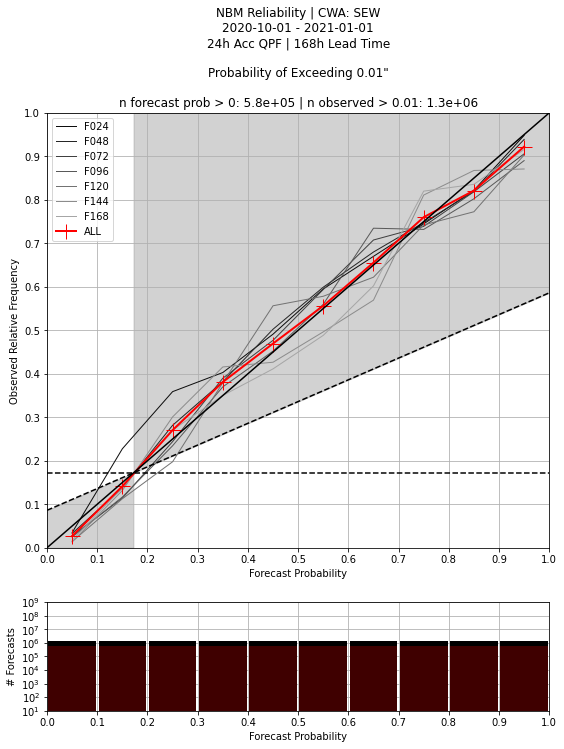

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/reliability/nbm4p0_SEW_reliability_0p10in.png


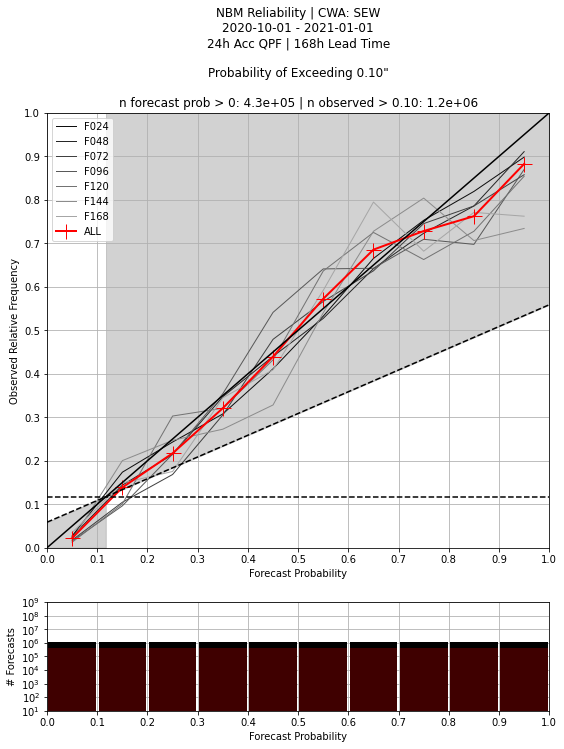

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/reliability/nbm4p0_SEW_reliability_0p25in.png


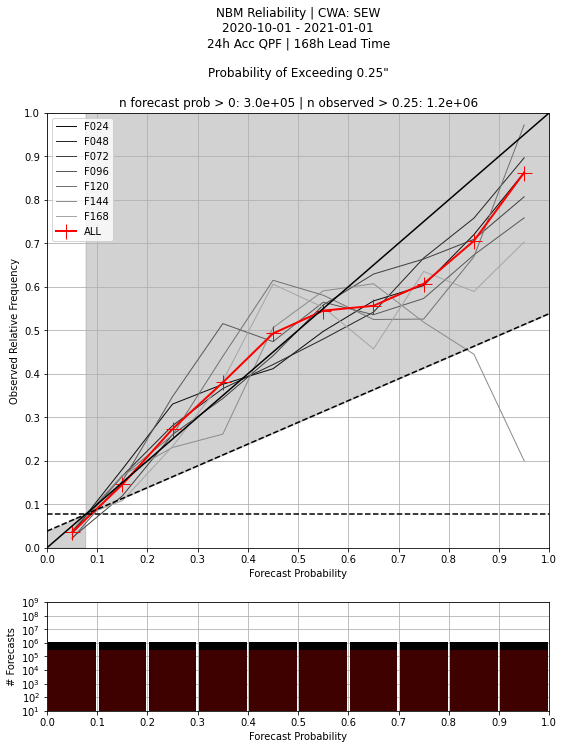

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/reliability/nbm4p0_SEW_reliability_0p50in.png


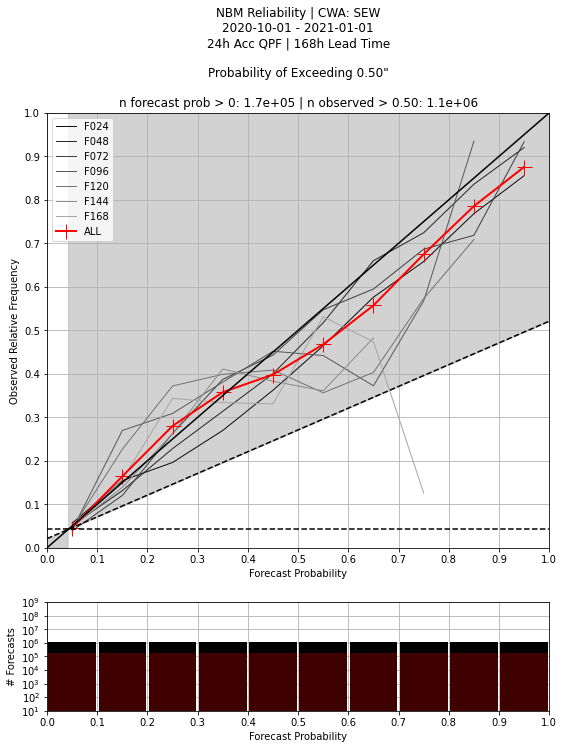

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/reliability/nbm4p0_SEW_reliability_1p00in.png


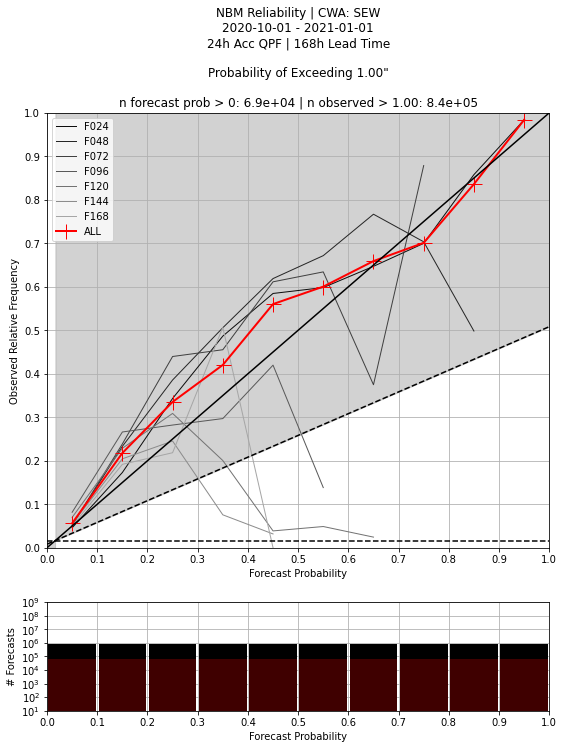

In [28]:
for thresh in produce_thresholds:
    
    fig = plt.figure(figsize=(9, 11), facecolor='w')
    axs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax = plt.subplot(axs[0])
    ax1 = plt.subplot(axs[1])
    
    relplot_agg = []
    shades = np.linspace(.05, .65, len(fhrs))
    for i, fhr in enumerate(fhrs):

        relplot = []
        for bin_data in data[fhr][thresh]:
            
            bins, n, N = bin_data[:-1]
            center = np.mean(bins)/100

            n = n.sum()
            N = N.sum()
            obs_rel_freq = (n/N)
        
            relplot.append([center, obs_rel_freq, n.sum(), N.sum()])
        
        relplot = np.array(relplot)
        relplot_agg.append(relplot)
        
        ax.plot(relplot[:, 0], relplot[:, 1], linewidth=1,
                label='F%03d'%fhr, color=str(shades[i]),
                #marker='+', markersize=15
               )
        
    relplot_agg = np.array(relplot_agg)
    
    relplot_agg = np.array(
        [relplot_agg.mean(axis=0)[:, 0], 
        relplot_agg.sum(axis=0)[:, 2]/relplot_agg.sum(axis=0)[:, 3]])


    ax.plot(relplot_agg[0], relplot_agg[1], linewidth=2, color='r',
            marker='+', markersize=15, label='ALL')

    perfect = np.arange(0, 1.1, .1)

    _urma, _mask = xr.broadcast(urma, mask)
    _urma = xr.where(_mask, _urma, np.nan)
    climo = xr.where((_urma > thresh), 1, 0).sum().values/_urma.size

    skill = perfect - ((perfect - climo)/2)

    ax.plot(perfect, perfect, 
            color='k')

    ax.axhline(climo, 
            color='k', linestyle='--')

    ax.plot(perfect, skill, 
            color='k', linestyle='--')

    fillperf = np.arange(climo, 1, .001)
    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
            color='gray', alpha=0.35)

    fillperf = np.arange(0, climo, .001)
    ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
            color='gray', alpha=0.35)

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.set_xticks(perfect)
    ax.set_yticks(perfect)

    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Observed Relative Frequency')
    ax.grid(zorder=1)
    
    date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

    ax.set_title((
        'NBM Reliability | CWA: %s\n'%cwa +
        '%s - %s\n'%(date0, date1) + 
        '%02dh Acc QPF | %3dh Lead Time\n\n'%(interval, fhr) +
        'Probability of Exceeding %.2f"\n\n'%thresh + 
        'n forecast prob > 0: %2.1e | n observed > %.2f: %2.1e'%(
            relplot[:, 2].sum(), thresh, relplot[:, 3].sum())))

    ax.legend(loc='upper left')

    # # # # # # # # # # # # # # # # # # # # # # # # 

    ax1.bar(relplot_agg[0], relplot[:, 3].sum(), color='k', width=0.095, zorder=10)
    ax1.bar(relplot_agg[0], relplot[:, 2].sum(), color='r', alpha=0.25, width=0.095, zorder=11)

    ax1.set_xticks(np.arange(0, 1.1, .1))
    ax1.set_xlim([0, 1])

    ax1.set_yscale('log')
    ax1.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])

    ax1.set_xlabel('Forecast Probability')
    ax1.set_ylabel('# Forecasts')
    ax1.grid(zorder=-1)

    plt.show()

# Lead-time Aggregate Map Plots

In [34]:
data['24-72'] = {}
data['96-168'] = {}

for fhrs_agg in [[24, 48, 72], [96, 120, 144, 168]]:

    for thresh in produce_thresholds:

        agg = []

        for fhr in fhrs_agg:

            for bin_data in data[fhr][thresh]:

                agg.append(bin_data)

        agg = np.array(agg)

        agg = agg.reshape(-1, 10, 4)
        bins = agg[0, :, 0]

        agg = agg.sum(axis=0)
        agg[:, 0] = bins

        data['%d-%d'%(fhrs_agg[0], fhrs_agg[-1])][thresh] = agg

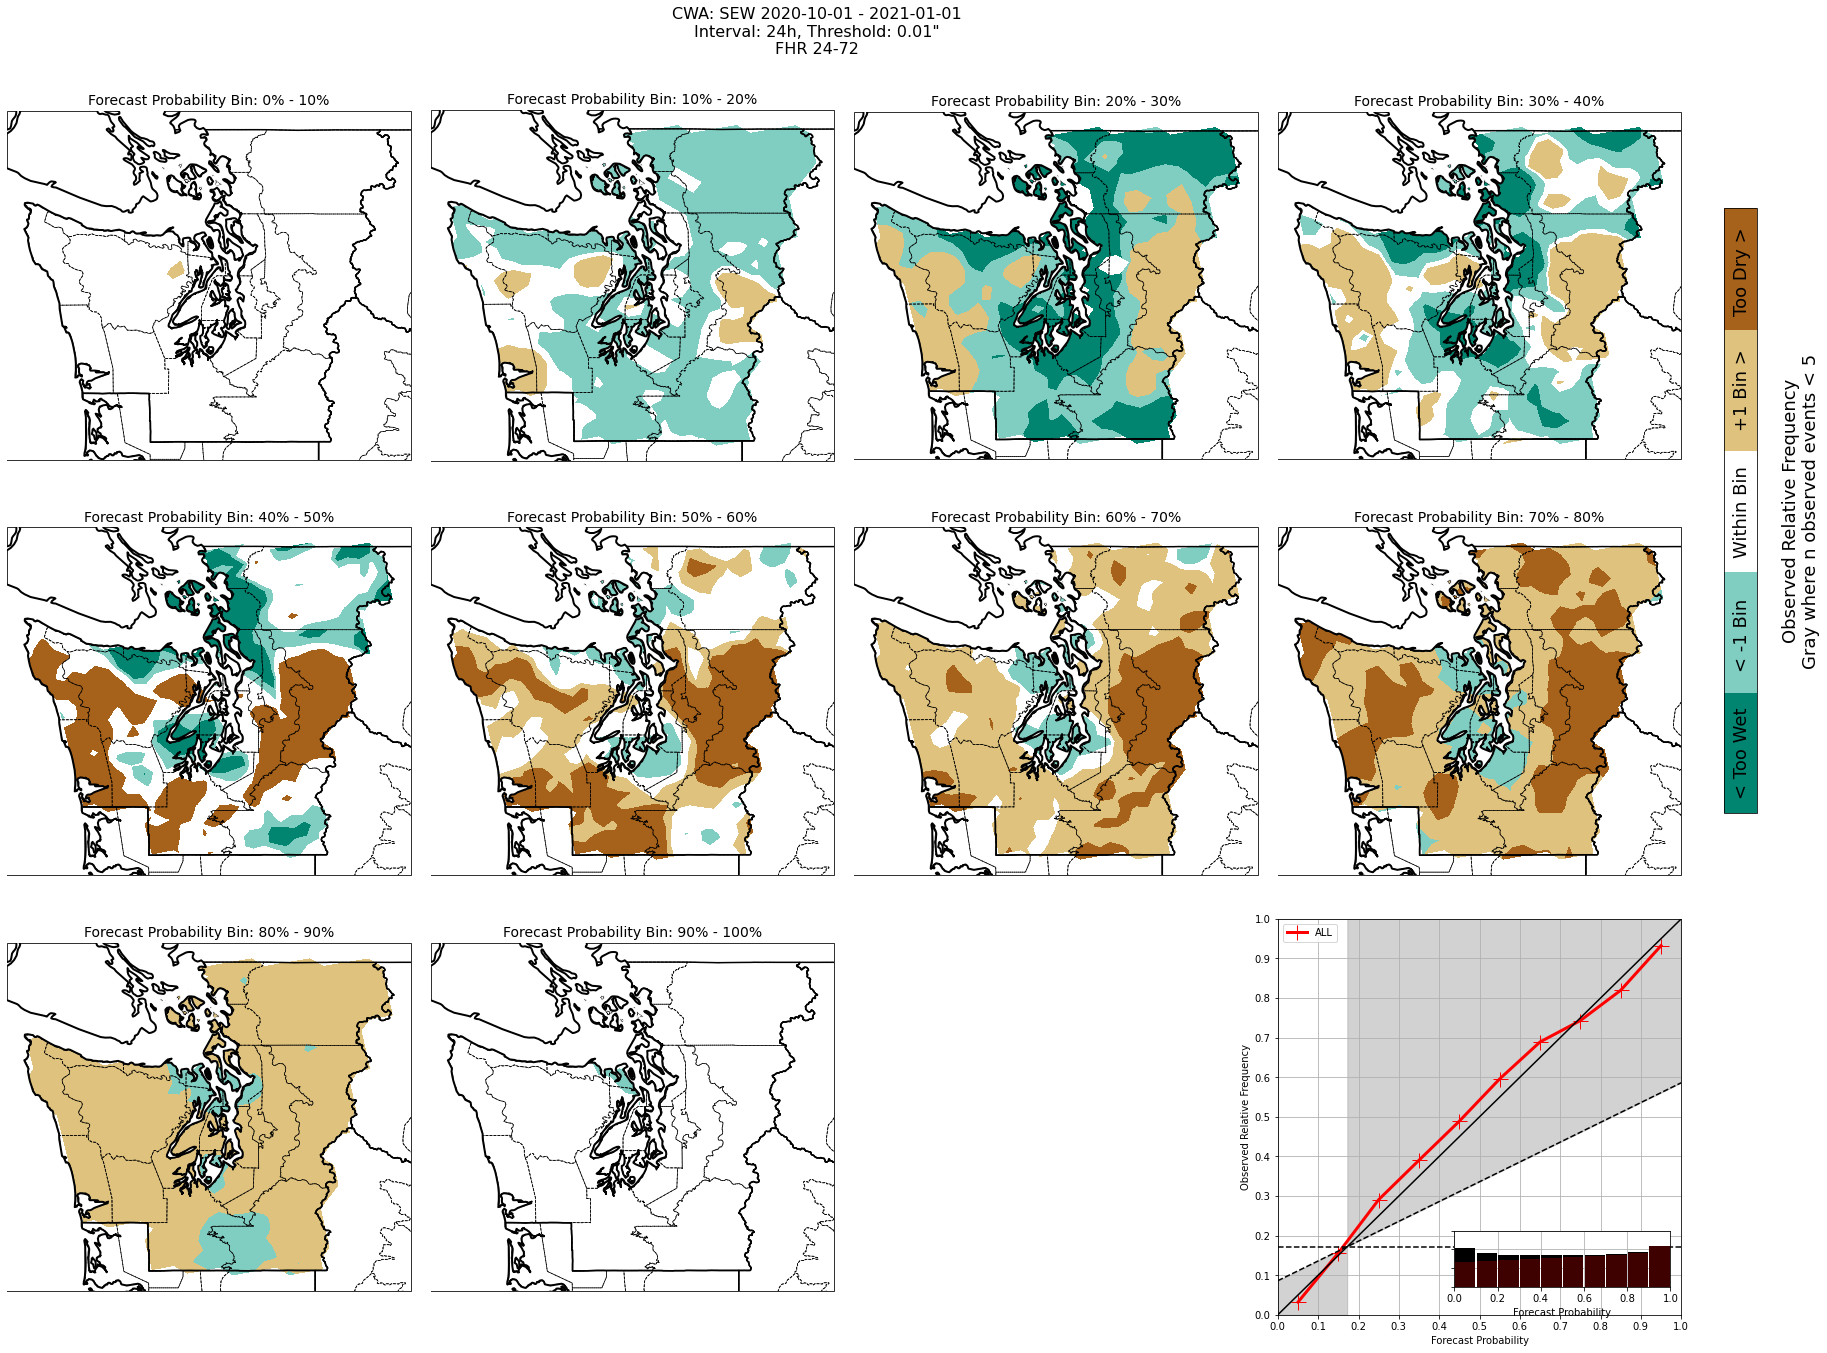

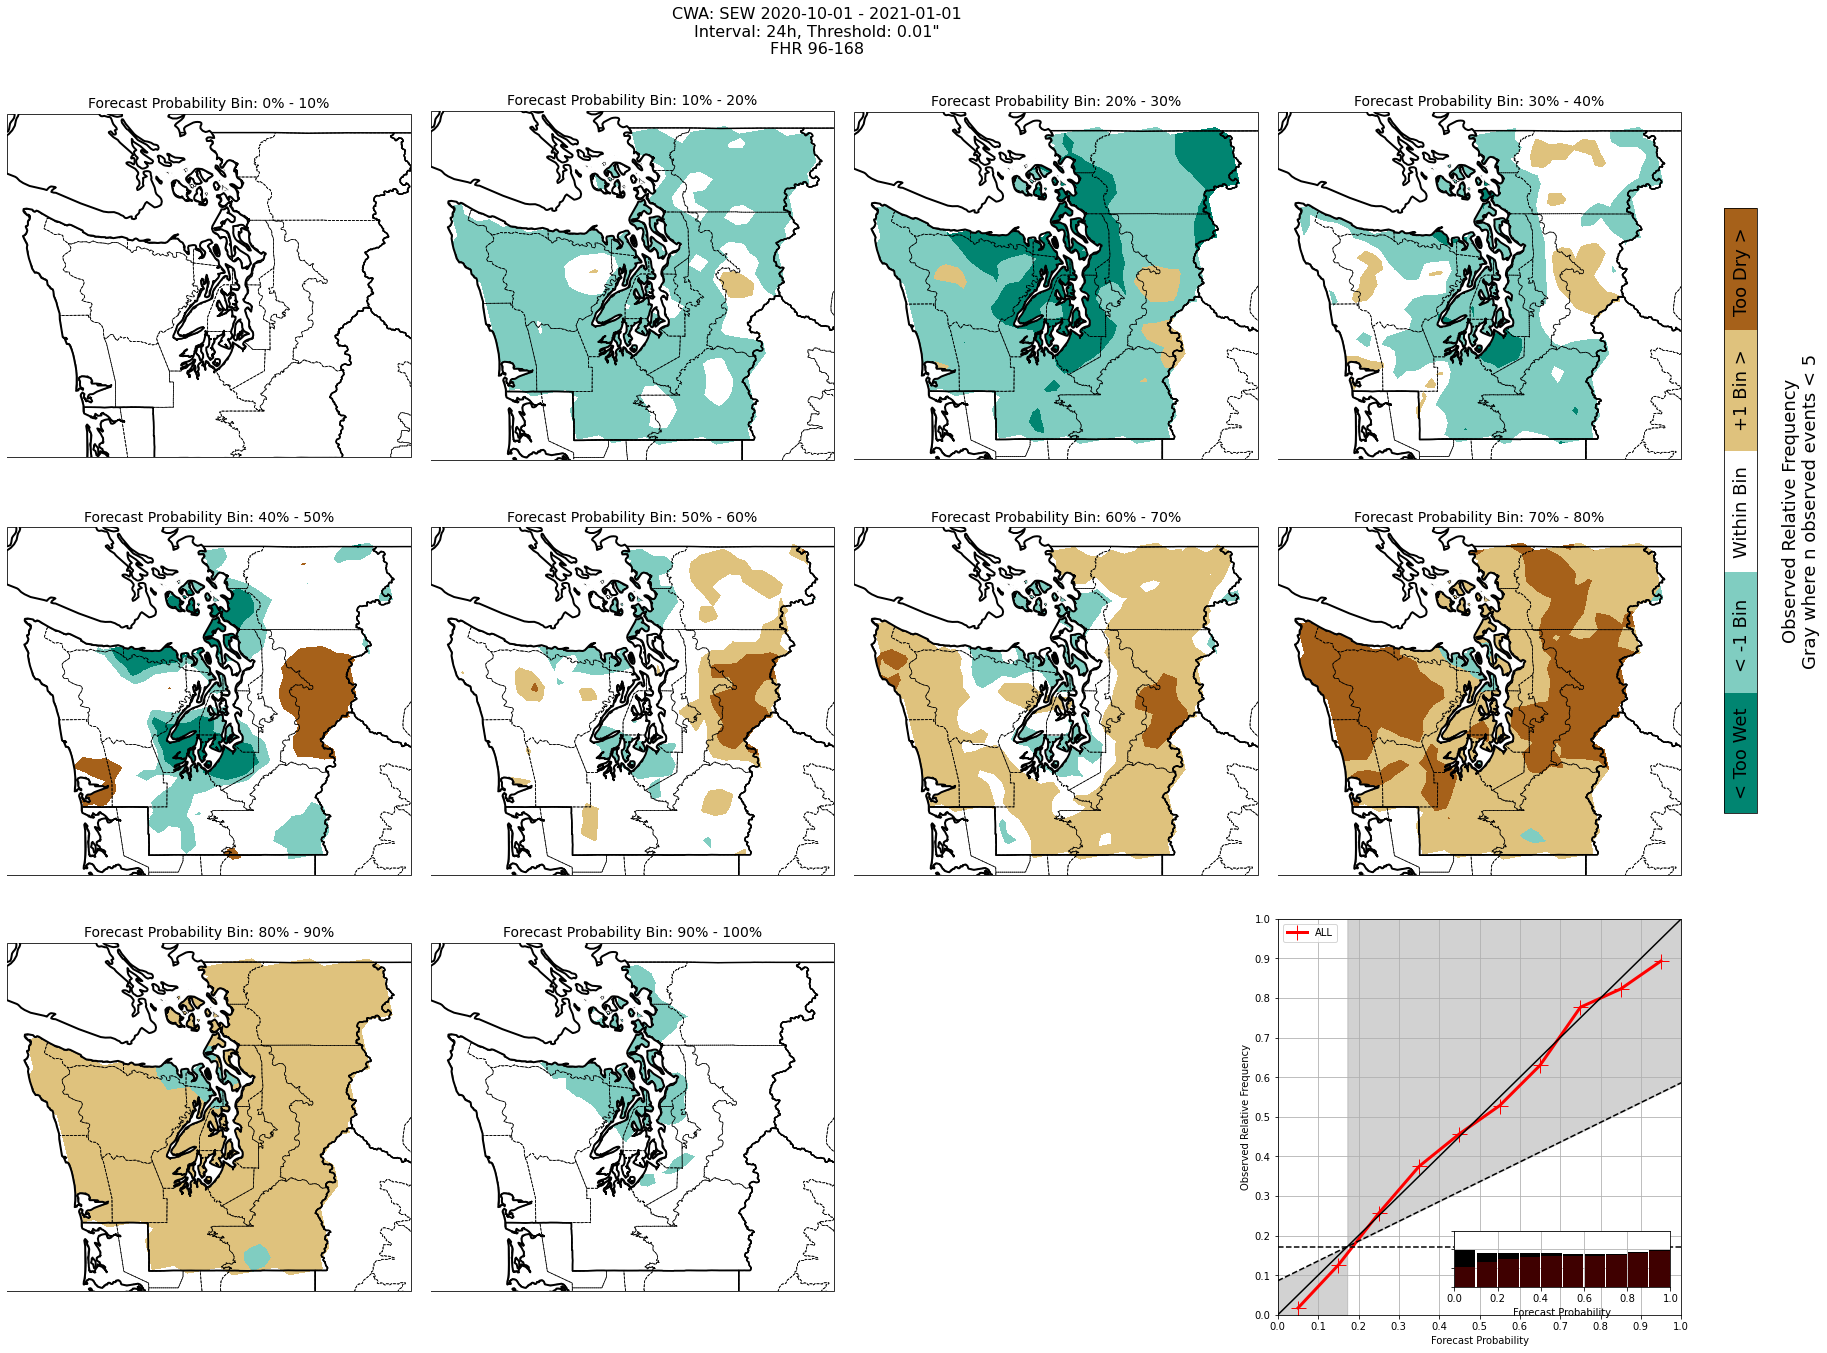

In [35]:
for fhr in ['24-72', '96-168']:

    for thresh in produce_thresholds[:1]:

        # Make the plot
        fig = plt.figure(figsize=(30, 28), facecolor='w')
        axs = [plt.subplot(4, 4, i+1, projection=ccrs.PlateCarree()) for i in range(10)]

        relplot = []
        for ax, bin_data in zip(axs, data[fhr][thresh]):

            bins, n, N = bin_data[:-1]
            n = n.coarsen(x=cx, y=cy, boundary='trim').sum()
            N = N.coarsen(x=cx, y=cy, boundary='trim').sum()
            obs_rel_freq = (n/N)*100

            levels, cmap, cbar_label = custom_cbar(bins)

            center = np.mean(bins)/100
            agg_obs_rel_freq = n.sum()/N.sum()
            relplot.append([center, agg_obs_rel_freq, n.sum(), N.sum()])

            if cwa != 'WESTUS':
                zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', linewidth=0.75, ax=ax)

            cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
            ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
            ax.coastlines(linewidth=2, zorder=101)

            cbd = ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, xr.where(n >= n_events, obs_rel_freq, np.nan),
                             levels=levels, cmap=cmap)

            try:
                nan_shade = xr.where((np.isnan(obs_rel_freq) | (n < n_events)) & mask, -1, np.nan)
                ax.contourf(obs_rel_freq.lon, obs_rel_freq.lat, nan_shade, cmap='gray', alpha=0.65)
            except:
                pass

            if cwa == 'SLC':
                # Square out the boundaries
                crg = ccrs.PlateCarree()
                LL = crg.transform_point(bounds[0], bounds[1], ccrs.Geodetic())
                UR = crg.transform_point(bounds[2], bounds[3], ccrs.Geodetic())
                EW = UR[0] - LL[0]
                SN = UR[1] - LL[1]
                side = max(EW, SN)
                mid_x, mid_y = LL[0]+EW/2.0, LL[1]+SN/2.0
                extent = [mid_x-side/1.25, mid_x+side/1.25, mid_y-side/1.75, mid_y+side/1.75]
                ax.set_extent(extent, crs=crg)

            ax.set_title('Forecast Probability Bin: %d%% - %d%%'%(bins[0], bins[1]), fontsize=14)

        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        cbar_ax = fig.add_axes([.92, .58, .015, .30])
        levels, cmap, cbar_label = custom_cbar((25, 75))
        norm = mpl.colors.BoundaryNorm(levels, cmap.N)
        cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, ticks=[], boundaries=levels)
        cbar.set_label(label=cbar_label, fontsize=18)

        date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
        plt.suptitle('CWA: %s %s - %s\nInterval: %02dh, Threshold: %.02f"\nFHR %s\n'%(cwa, date0, date1, interval, thresh, fhr), fontsize=16)
        fig.subplots_adjust(top=0.94)

        # Reliability Plot
        relplot = np.array(relplot)
        ax = plt.subplot(4, 4, 12)
        ax.plot(relplot[:, 0], relplot[:, 1], linewidth=3, color='r',
                marker='+', markersize=15, label='ALL')

        perfect = np.arange(0, 1.1, .1)

        _urma, _mask = xr.broadcast(urma, mask)
        _urma = xr.where(_mask, _urma, np.nan)
        climo = xr.where((_urma > thresh), 1, 0).sum().values/_urma.size    

        skill = perfect - ((perfect - climo)/2)

        ax.plot(perfect, perfect, 
                color='k')

        ax.axhline(climo, 
                color='k', linestyle='--')

        ax.plot(perfect, skill, 
                color='k', linestyle='--')

        fillperf = np.arange(climo, 1, .001)
        ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
                color='gray', alpha=0.35)

        fillperf = np.arange(0, climo, .001)
        ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
                color='gray', alpha=0.35)

        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        ax.set_xticks(perfect)
        ax.set_yticks(perfect)

        ax.set_xlabel('Forecast Probability')
        ax.set_ylabel('Observed Relative Frequency')
        ax.grid(zorder=1)

        ax.legend(loc='upper left')

        # # # # # # # # # # # # # # # # # # # # # # # #
        ax1 = plt.axes([.795, .345, .1, .028], facecolor='w')

        ax1.bar(relplot[:, 0], relplot[:, 3], color='k', width=0.095, zorder=10)
        ax1.bar(relplot[:, 0], relplot[:, 2], color='r', alpha=0.25, width=0.095, zorder=11)

        ax1.set_xlim([0, 1])

        ax1.set_yscale('log')
        ax1.set_yticks([1e2, 1e4, 1e6, 1e8])
        ax1.set_yticklabels([])

        ax1.set_xlabel('Forecast Probability')
        #ax1.set_ylabel('# Forecasts')
        ax1.grid(zorder=-1)

        cbar.ax.text(27, 83, 'Too Dry >', rotation=90, fontsize=18)
        cbar.ax.text(27, 64, '+1 Bin >', rotation=90, fontsize=18)
        cbar.ax.text(27, 43, 'Within Bin', rotation=90, fontsize=18)
        cbar.ax.text(27, 24, '< -1 Bin', rotation=90, fontsize=18)
        cbar.ax.text(27, 3, '< Too Wet', rotation=90, fontsize=18)

        plt.show()

# ROC Curves

#### Begin with FAR and HR
n is hit rate
N is part of hit + miss

H = POD = hit / (hit + miss)

Note that in basic testing, increased bin width inflates AUC

### Lead Time Aggregate ROC Curves

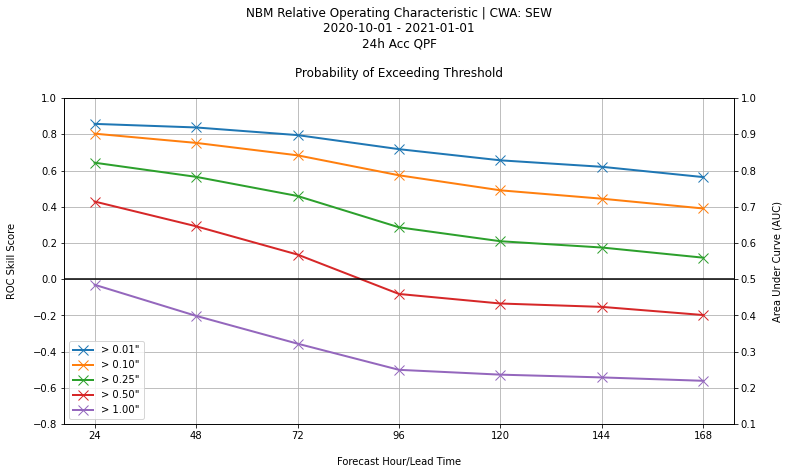

In [36]:
bin_list = [i[0] for i in data[fhrs[0]][produce_thresholds[0]]]

fig, ax = plt.subplots(1, facecolor='w', figsize=(12, 6))

for thresh in produce_thresholds:
    
    rocplot_agg_data = {np.mean(bins)/100:{k:[] for k in ['a', 'b', 'c', 'd']} for bins in bin_list}    
    
    rocss_plot = []
    for i, fhr in enumerate(fhrs):
        
        rocplot = [[1, 1, 1]]
        for bin_data in data[fhr][thresh]:

            bins = bin_data[0]
            center = np.mean(bins)/100
            
            con_table = bin_data[-1]
            a, b, c, d = [i.sum().values for i in con_table]
            
            pod = a / (a + c)
            far = b / (a + b)
            
            rocplot.append([far, pod, center])
            rocplot_agg_data[center]['a'].append(a)
            rocplot_agg_data[center]['b'].append(b)
            rocplot_agg_data[center]['c'].append(c)
            rocplot_agg_data[center]['d'].append(d)

        rocplot.append([0, 0, 0])
        rocplot = np.array(rocplot)

        # Use simpson's rule to calculate AUC 
        auc = simps(rocplot[:, 1], dx=bint)/100
        roc_ss = 2 * (auc - 0.5)
        
        rocss_plot.append([fhr, roc_ss, auc, thresh])
    
    rocss_plot = np.array(rocss_plot)
    ax.plot(rocss_plot[:, 0], rocss_plot[:, 1],
            marker='x', markersize=10, linewidth=2,
            label='> %.2f"'%np.unique(rocss_plot[:, 3])[0])

ax.axhline(0, color='k')
ax.set_xticks(rocss_plot[:, 0])
ax.set_xlabel('\nForecast Hour/Lead Time')

axx = ax.twinx()
ax.set_yticks(ax.get_yticks())
axx.set_yticks(ax.get_yticks())
axx.set_yticklabels(['%.1f'%v for v in ax.get_yticks()/2 + 0.5])

ax.set_ylabel('ROC Skill Score\n')
axx.set_ylabel('\nArea Under Curve (AUC)')

date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
ax.set_title((
    'NBM Relative Operating Characteristic | CWA: %s\n'%cwa +
    '%s - %s\n'%(date0, date1) + 
    '%02dh Acc QPF\n\n'%(interval) +
    'Probability of Exceeding Threshold\n'))

ax.grid()
ax.legend(loc='lower left')
plt.show()

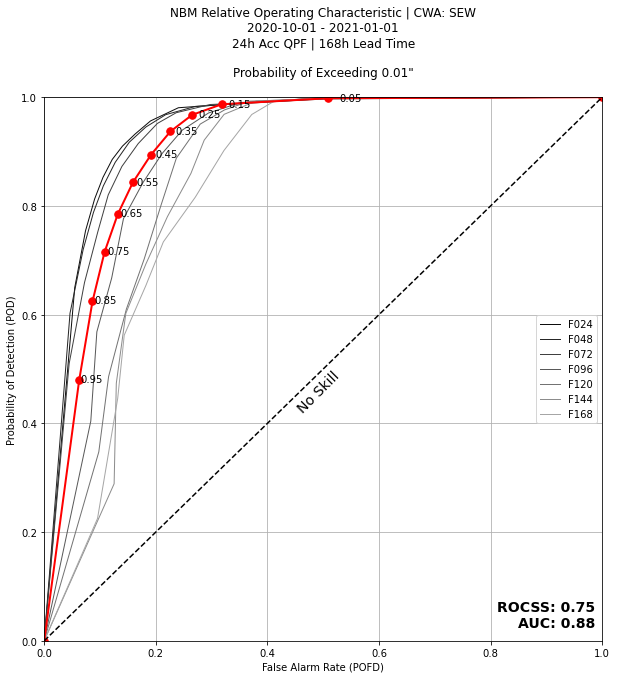

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/roc/nbm4p0_SEW_roc_0p01in.png


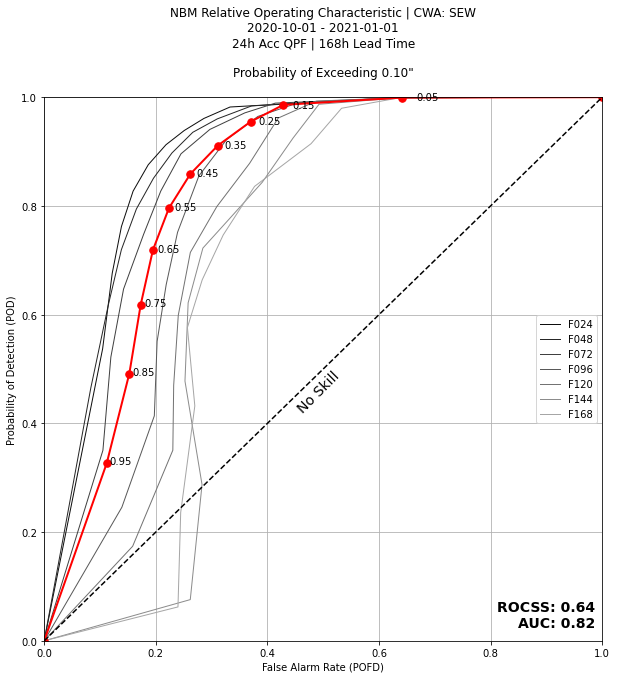

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/roc/nbm4p0_SEW_roc_0p10in.png


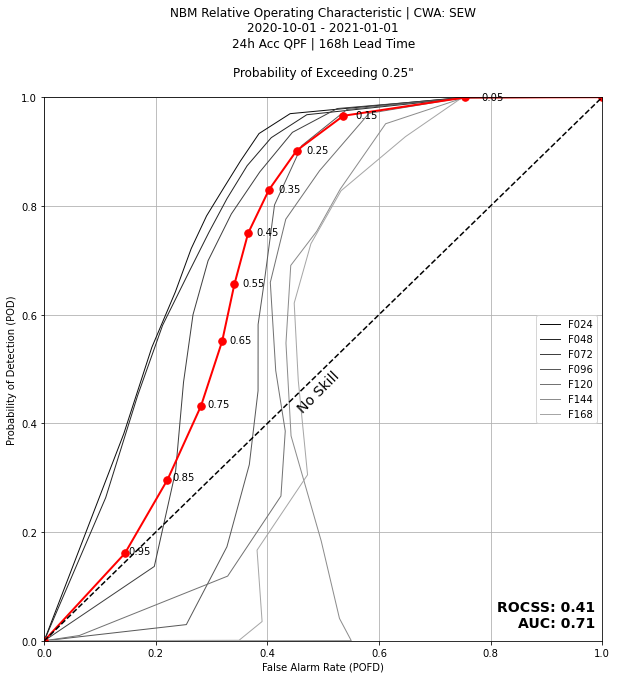

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/roc/nbm4p0_SEW_roc_0p25in.png


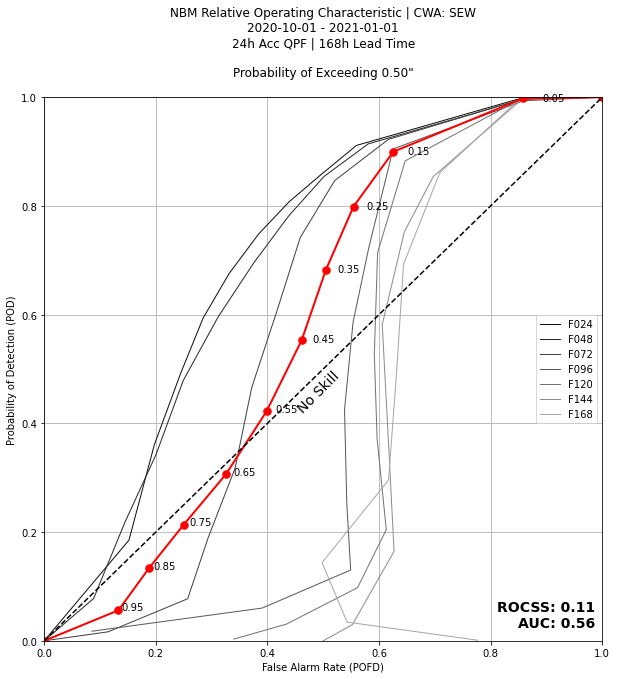

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/roc/nbm4p0_SEW_roc_0p50in.png


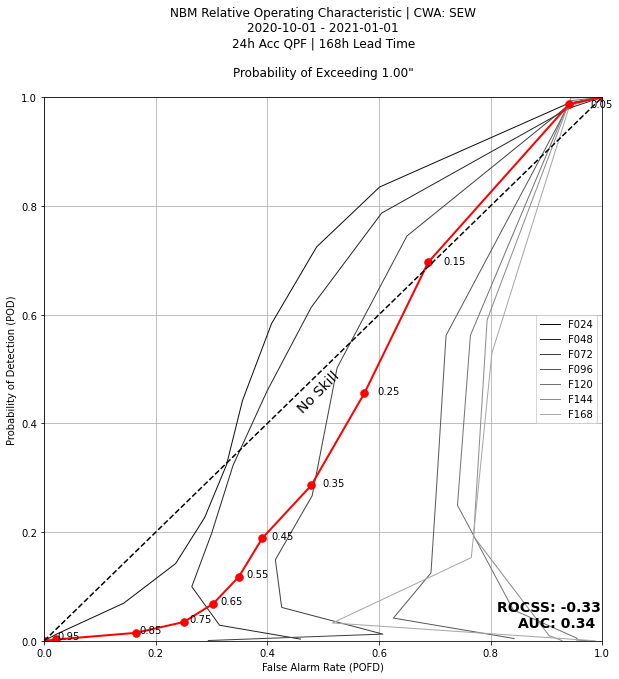

/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/nbm/4p0/SEW/roc/nbm4p0_SEW_roc_1p00in.png


In [40]:
bin_list = [i[0] for i in data[fhrs[0]][produce_thresholds[0]]]

for thresh in produce_thresholds:
    
    rocplot_agg_data = {np.mean(bins)/100:{k:[] for k in ['a', 'b', 'c', 'd']} for bins in bin_list}    
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')
    
    shades = np.linspace(.05, .65, len(fhrs))
    for i, fhr in enumerate(fhrs):
        
        rocplot = [[1, 1, 1]]
        for bin_data in data[fhr][thresh]:

            bins = bin_data[0]
            center = np.mean(bins)/100
            
            con_table = bin_data[-1]
            a, b, c, d = [i.sum().values for i in con_table]
            
            pod = a / (a + c)
            far = b / (a + b)
            
            rocplot.append([far, pod, center])
            rocplot_agg_data[center]['a'].append(a)
            rocplot_agg_data[center]['b'].append(b)
            rocplot_agg_data[center]['c'].append(c)
            rocplot_agg_data[center]['d'].append(d)
        
        rocplot.append([0, 0, 0])
        rocplot = np.array(rocplot)
        
        ax.plot(rocplot[:, 0], rocplot[:, 1], linewidth=1, label='F%03d'%fhr,
               color=str(shades[i]))
     
    rocplot_agg = [[1, 1, 1]]
    for center in rocplot_agg_data.keys():
        a, b, c, d = [np.sum(rocplot_agg_data[center][i]) for i in ['a', 'b', 'c', 'd']]
        pod = a / (a + c)
        far = b / (a + b)
        rocplot_agg.append([far, pod, center])
    rocplot_agg.append([0, 0, 0])
    rocplot_agg = np.array(rocplot_agg)
    
    # Use simpson's rule to calculate AUC 
    auc = simps(rocplot_agg[:, 1], dx=bint)/100
    roc_ss = 2 * (auc - 0.5)

    ax.plot(rocplot_agg[:, 0], rocplot_agg[:, 1], marker='o', markersize=7.5, color='r', linewidth=2)
    [ax.text(x*1.04, y*.995, s, fontsize=10) for x, y, s in rocplot_agg[1:-1]]
    
    ax.plot(np.arange(0, 1.1), np.arange(0, 1.1), 'k--')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
    ax.set_title((
        'NBM Relative Operating Characteristic | CWA: %s\n'%cwa +
        '%s - %s\n'%(date0, date1) + 
        '%02dh Acc QPF | %3dh Lead Time\n\n'%(interval, fhr) +
        'Probability of Exceeding %.2f"\n'%thresh))

    ax.set_xlabel('False Alarm Rate (POFD)')
    ax.set_ylabel('Probability of Detection (POD)')
    ax.text(.45, .42, 'No Skill', rotation=45, fontsize=14)
    ax.text(.812, .055, 'ROCSS: %.2f'%roc_ss, rotation=0, fontsize=14, weight='bold')
    ax.text(.85, .025, 'AUC: %.2f'%auc, rotation=0, fontsize=14, weight='bold')

    ax.grid()
    ax.legend(loc='center right')
    
    plt.show()
    
    savedir = fig_dir + '%s/%s/roc/'%(ver, cwa)
    os.makedirs(savedir, exist_ok=True)
    
    savestr = 'nbm{}_{}_roc_{}in.png'.format(
        ver, cwa, ('%.2f'%thresh).replace('.', 'p'))
    
    print(savedir + savestr)

## BSS

In [42]:
extract_brier_mp = partial(extract_brier, _urma=urma)

with mp.get_context('fork').Pool(8) as p:
    returns = p.map(extract_brier_mp, fhrs)
    p.close()
    p.join()

returns = [r for r in returns if r is not None]
brier = xr.concat(returns, dim='fhr')

/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr024.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr048.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr072.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr096.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr120.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr144.nc
/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr168.nc


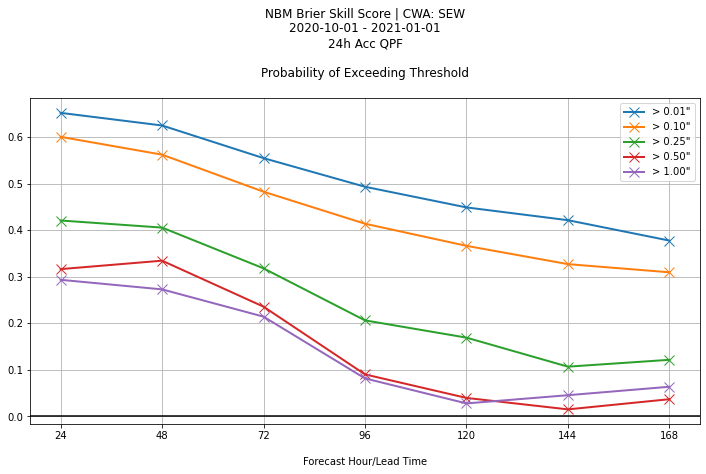

In [45]:
bss = brier['BSS']

fig, ax = plt.subplots(1, facecolor='w', figsize=(12, 6))

for thresh, bss_values in bss.mean(dim=['x', 'y']).groupby('threshold'):
    ax.plot(bss_values.fhr, bss_values, label='> %.2f"'%thresh,
            marker='x', markersize=10, linewidth=2)

ax.axhline(0, color='k')
ax.set_xticks(bss.fhr)
ax.set_xlabel('\nForecast Hour/Lead Time')
    
date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
ax.set_title((
    'NBM Brier Skill Score | CWA: %s\n'%cwa +
    '%s - %s\n'%(date0, date1) + 
    '%02dh Acc QPF\n\n'%(interval) +
    'Probability of Exceeding Threshold\n'))
    
ax.grid()
ax.legend(loc='upper right')

plt.show()

In [52]:
for fhr in [np.arange(24, 72.1, 24), np.arange(96, 168.1, 24)]:

    # Make the plot
    fig = plt.figure(figsize=(30, 12), facecolor='w')
    axs = [plt.subplot(2, 5, i+1, projection=ccrs.PlateCarree()) for i in range(2*5)]

    for i in range(len(brier.thresh)):

        _brier = brier.isel(thresh=i).sel(fhr=fhr).mean(dim='fhr')

        bs = _brier['BS']
        bss = _brier['BSS']

        ax0, ax1 = axs[i], axs[i+5]
    
        for ax in [ax0, ax1]:
            ax.set_xlim([bounds[0]-.1, bounds[2]+.1])
            ax.set_ylim([bounds[1]-.1, bounds[3]+.1])

            zones.geometry.boundary.plot(color=None, linestyle='--', edgecolor='black', linewidth=0.75, ax=ax)
            cwas.geometry.boundary.plot(color=None, edgecolor='black', linewidth=1.5, ax=ax)
            ax.add_feature(cartopy.feature.OCEAN, zorder=100, color='w', edgecolor=None)
            ax.coastlines(linewidth=2, zorder=101)
        
        ax0.set_title('Threshold: %.2f"\n\nBrier Skill Score: %.3f'%(bss.threshold, bss.mean()))
        ax1.set_title('Brier Score: %.3f'%(bs.mean()))
        
        #####
        
        bss_levels = np.append(-1, np.arange(0, 1.1, .2))
        
        base_colors = [plt.cm.viridis(i) for i in range(plt.cm.viridis.N)]
        base_colors[0] = 'gray'
        
        cmap0 = colors.ListedColormap(base_colors)
        norm0 = mpl.colors.BoundaryNorm(bss_levels, cmap0.N)
        
        bss_kwargs = dict(
            vmin=bss_levels[0], vmax=bss_levels[-1],
            levels=bss_levels,
            cmap=cmap0, norm=norm0)
        
        cbd0 = ax0.contourf(bss.lon, bss.lat, bss, **bss_kwargs)
        
        #####
        
        bs_levels = np.arange(0, .31, .05)

        cmap1 = colors.ListedColormap(base_colors[1:][::-1])
        norm1 = mpl.colors.BoundaryNorm(bs_levels, cmap1.N)
        
        bs_kwargs = dict(
            vmin=bs_levels[0], vmax=bs_levels[-1],
            levels=bs_levels,
            cmap=cmap1, norm=norm1)
        
        cbd1 = ax1.contourf(bs.lon, bs.lat, bs, **bs_kwargs)
        
        #####
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    cax0 = fig.add_axes([.91, .525, .01, .3])
    cbar0 = mpl.colorbar.ColorbarBase(cax0, cmap=cmap0, norm=norm0, 
                                      boundaries=bss_kwargs['levels'])
    cbar0.set_label(label='Brier Skill Score')
    
    cax1 = fig.add_axes([.91, .155, .01, .3])
    cbar1 = mpl.colorbar.ColorbarBase(cax1, cmap=cmap1, norm=norm1, 
                                      boundaries=bs_kwargs['levels'])
    cbar1.set_label(label='Brier Score')
    
    date0, date1 = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
    plt.suptitle('CWA: %s %s - %s\nInterval: %02dh\nFHR %s\n'%(cwa, date0, date1, interval, '%d – %d'%(fhr[0], fhr[-1])), fontsize=14)
    fig.subplots_adjust(top=0.85)
    
    plt.show()

nbm4p0_SEW_bss_map_fhr24-72.png
nbm4p0_SEW_bss_map_fhr96-168.png
